# Generic Imports

In [1]:
import pandas as pd
import numpy as np

# Usefull functions

In [4]:
def drop_additionals(df):
    df_cols = ["type","play_pattern","possession_team","position","under_pressure","counterpress","out","location_x","location_y","shot_outcome"]
    df= df[df['location_available']==True][df_cols].reset_index()
    df = df.drop(columns=['index'])
    return df

In [5]:
def normalize_data(df):
    # normalizing position data
    field_length = 120
    field_width = 80
    df['location_x'] = df['location_x']/field_length
    df['location_y'] = df['location_y']/field_width

    # creating dummies from categorical data
    df = pd.get_dummies(df, columns=["type","play_pattern","position"])

    # creating dummies for team data
    possesion_teams = df['possession_team'].unique()
    df['team'] = df['possession_team'].apply(lambda x: 1 if  x == possesion_teams[1] else 0)

    # changing true/false to 1/0
    df.replace({False: 0, True: 1}, inplace = True)

    return df


In [6]:
def create_labels(df):
    # labeling when a goal is scored
    scored = df['shot_outcome'].apply(lambda x: True if x == 'Goal' else False)
    df = df.drop(columns=['shot_outcome'])

    scored_0 = list(scored & (df['team']==0))
    scored_1 = list(scored & (df['team']==1))

    # setting up target scored 
    predict_window = 10
    scored = scored_0 + ([False] * predict_window)
    scored_window_0 = list(map(lambda x: 1 if any(scored[x:x+predict_window]) else 0,range(0,len(df))))

    scored = scored_1 + ([False] * predict_window)
    scored_window_1 = list(map(lambda x: 1 if any(scored[x:x+predict_window]) else 0,range(0,len(df))))

    df['scored_window'] = (scored_window_1 * (df['team']==1)) | (scored_window_0 * (df['team']==0))
    df['conceded_window'] = (scored_window_0 * (df['team']==1)) | (scored_window_1 * (df['team']==0))

    return df

In [7]:
def compile_state(df,targets, state_len =3):
    offset_df = []
    for i in range(state_len):
        df_ = df.shift(i).copy(deep=True)
        df_ = df_.rename(lambda x: x+f'_{i}',axis='columns').reset_index()
        offset_df.append(df_)


    df_ = offset_df[0]
    for df__ in offset_df[1:]:
        df_ = df_.merge(df__,how='inner')

    # joining target cols
    for target in targets:
        df_[target] = df_[f'{target}_2']
        drop_cols = []
        for i in range(0,state_len):
            drop_cols.append(f'{target}_{i}')

        df_ = df_.drop(columns = drop_cols)

    df_.replace({False: 0, True: 1}, inplace = True)
    df_ = df_.drop(columns=['index'])
    return df_

# Preprocessing

In [371]:
from preprocessing import event_preprocessing
from preprocessing import drop_unprocessed 

df = pd.read_json('data/15946.json')
df = event_preprocessing(df)
df = drop_unprocessed(df)

player.... complete
type.... complete
play_pattern.... complete
possession_team.... complete
position.... complete
location.... complete
under_pressure.... complete
counterpress.... complete
off_camera.... complete
out.... complete
carry.... complete
ball_receipt.... complete
shot.... complete
dribble.... complete
pass.... complete


# Metric 2

## Preparing data for training model

In [6]:
df = drop_additionals(df)
df.head()

NameError: name 'df' is not defined

In [373]:
df = normalize_data(df)
df = df.drop(columns=['possession_team','under_pressure','counterpress','out'])

In [374]:
df = create_labels(df)

In [375]:
# scored
targets = ["scored_window","conceded_window"]
df = compile_state(df,targets)[2:]

In [376]:
df['team'] = df['team_2']
df['P_scoring'] = df['scored_window']

df_concede = df.copy(deep=True)
df_concede['team'] != df_concede['team']
df_concede['P_scoring'] = df_concede['conceded_window']

# joining two dataframes
df = pd.concat([df,df_concede])

In [377]:
X = df.drop(columns=['scored_window']).to_numpy()
Y = df['scored_window'].to_numpy()

In [253]:
print(f'input shape: {X.shape}')
print(f'output shape: {Y.shape}')

input shape: (7478, 12)
output shape: (7478,)


In [254]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X,Y,test_size=0.25)

## Training Model (First Try)

In [255]:
import xgboost as xgb

In [256]:
# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=10)
# Fit the model, test sets are used for early stopping.
clf.fit(train_X, train_Y, eval_set=[(test_X, test_Y)])

[0]	validation_0-logloss:0.44140
[1]	validation_0-logloss:0.30242
[2]	validation_0-logloss:0.21511
[3]	validation_0-logloss:0.15696
[4]	validation_0-logloss:0.11699
[5]	validation_0-logloss:0.08898
[6]	validation_0-logloss:0.06916
[7]	validation_0-logloss:0.05499
[8]	validation_0-logloss:0.04499
[9]	validation_0-logloss:0.03730
[10]	validation_0-logloss:0.03194
[11]	validation_0-logloss:0.02771
[12]	validation_0-logloss:0.02443
[13]	validation_0-logloss:0.02241
[14]	validation_0-logloss:0.02081
[15]	validation_0-logloss:0.01974
[16]	validation_0-logloss:0.01841
[17]	validation_0-logloss:0.01731
[18]	validation_0-logloss:0.01695
[19]	validation_0-logloss:0.01675
[20]	validation_0-logloss:0.01622
[21]	validation_0-logloss:0.01595
[22]	validation_0-logloss:0.01554
[23]	validation_0-logloss:0.01493
[24]	validation_0-logloss:0.01482
[25]	validation_0-logloss:0.01441
[26]	validation_0-logloss:0.01455
[27]	validation_0-logloss:0.01428
[28]	validation_0-logloss:0.01380
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

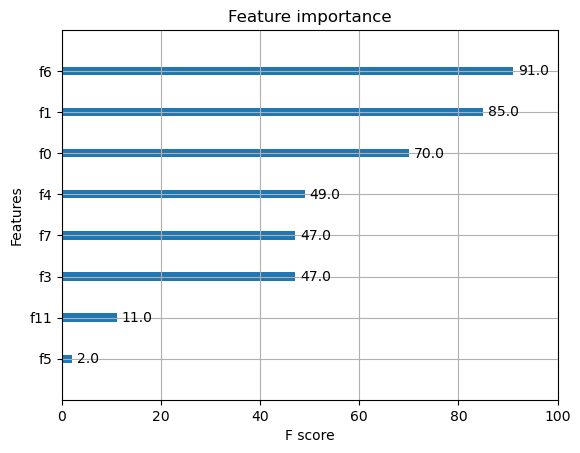

In [257]:
xgb.plot_importance(clf)

In [258]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
predict_Y = clf.predict(test_X)
accuracy_score(predict_Y, test_Y)

0.9967914438502674

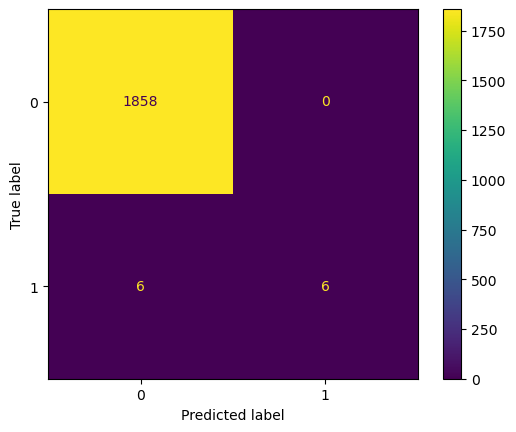

In [259]:
confusion_matrix = confusion_matrix(test_Y, predict_Y)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0,1])

cm_display.plot()

## Training Model (Second Try)

In [29]:
from preprocessing import event_preprocessing
from preprocessing import drop_unprocessed 
def import_matches(files):
    dfs = []
    for file in files: 
        print(f'analysing {file}\n')
        df = pd.read_json(file)
        df = event_preprocessing(df)
        df = drop_unprocessed(df)

        df = drop_additionals(df)

        df = normalize_data(df)
        df = df.drop(columns=['possession_team','under_pressure','counterpress','out'])

        df = create_labels(df)

        # scored
        targets = ["scored_window","conceded_window"]
        df = compile_state(df,targets)[2:]

        df['team'] = df['team_2']
        #df['P_scoring'] = df['scored_window']

        #df_concede = df.copy(deep=True)
        #df_concede['team'] != df_concede['team']
        #df_concede['P_scoring'] = df_concede['conceded_window']

        # joining two dataframes
        dfs.append(df)

    return pd.concat(dfs)

In [30]:
df2 = import_matches(['data/15946.json','data/15956.json', 'data/15973.json'])

analysing data/15946.json

player.... complete
type.... complete
play_pattern.... complete
possession_team.... complete
team.... complete
position.... complete
location.... complete
under_pressure.... complete
counterpress.... complete
off_camera.... complete
out.... complete
carry.... complete
ball_receipt.... complete
shot.... complete
dribble.... complete
pass.... complete
analysing data/15956.json

player.... complete
type.... complete
play_pattern.... complete
possession_team.... complete
team.... complete
position.... complete
location.... complete
under_pressure.... complete
counterpress.... complete
off_camera.... complete
out.... complete
carry.... complete
ball_receipt.... complete
shot.... complete
dribble.... complete
pass.... complete
analysing data/15973.json

player.... complete
type.... complete
play_pattern.... complete
possession_team.... complete
team.... complete
position.... complete
location.... complete
under_pressure.... complete
counterpress.... complete
off_ca

In [31]:
df2.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10478 entries, 2 to 3420
Data columns (total 162 columns):
 #    Column                                Dtype  
---   ------                                -----  
 0    location_x_0                          float64
 1    location_y_0                          float64
 2    type_Ball Receipt*_0                  uint8  
 3    type_Ball Recovery_0                  uint8  
 4    type_Block_0                          uint8  
 5    type_Carry_0                          uint8  
 6    type_Clearance_0                      uint8  
 7    type_Dispossessed_0                   uint8  
 8    type_Dribble_0                        uint8  
 9    type_Dribbled Past_0                  uint8  
 10   type_Duel_0                           uint8  
 11   type_Error_0                          float64
 12   type_Foul Committed_0                 uint8  
 13   type_Foul Won_0                       uint8  
 14   type_Goal Keeper_0                    uint8  
 15   t

In [32]:
df2 = df2.loc[:,:'team']

In [33]:
ammount_scores = list(df2['scored_window']==1).count(1)
df2_score = pd.concat([df2[df2['scored_window']==1].copy(deep=True), df2[df2['scored_window']==0].copy(deep=True).sample(n=2*ammount_scores)])

ammount_concedes = list(df2['conceded_window']==1).count(1)
df2_concedes = pd.concat([df2[df2['conceded_window']==1].copy(deep=True), df2[df2['conceded_window']==0].copy(deep=True).sample(n=2*ammount_scores)])

### creating model for P_score

In [54]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_scores = df2_score.drop(columns=['scored_window','conceded_window']).to_numpy()
Y_scores = df2_score['scored_window'].to_numpy()
train_X, test_X, train_Y, test_Y = train_test_split(X_scores,Y_scores,test_size=0.25)

# Use "hist" for constructing the trees, with early stopping enabled.
clf_score = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=50) 
# Fit the model, test sets are used for early stopping.
clf_score.fit(train_X, train_Y, eval_set=[(test_X, test_Y)])

[0]	validation_0-rmse:0.45057
[1]	validation_0-rmse:0.43470
[2]	validation_0-rmse:0.41570
[3]	validation_0-rmse:0.39561
[4]	validation_0-rmse:0.39648
[5]	validation_0-rmse:0.39086
[6]	validation_0-rmse:0.38600
[7]	validation_0-rmse:0.38719
[8]	validation_0-rmse:0.37823
[9]	validation_0-rmse:0.37517
[10]	validation_0-rmse:0.37323
[11]	validation_0-rmse:0.37322
[12]	validation_0-rmse:0.37456
[13]	validation_0-rmse:0.37379
[14]	validation_0-rmse:0.37359
[15]	validation_0-rmse:0.37389
[16]	validation_0-rmse:0.37376
[17]	validation_0-rmse:0.37319
[18]	validation_0-rmse:0.37246
[19]	validation_0-rmse:0.37267
[20]	validation_0-rmse:0.37263
[21]	validation_0-rmse:0.37138
[22]	validation_0-rmse:0.37289
[23]	validation_0-rmse:0.37161
[24]	validation_0-rmse:0.37134
[25]	validation_0-rmse:0.37106
[26]	validation_0-rmse:0.37130
[27]	validation_0-rmse:0.37218
[28]	validation_0-rmse:0.37147
[29]	validation_0-rmse:0.37119
[30]	validation_0-rmse:0.37136
[31]	validation_0-rmse:0.37136
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [55]:
from sklearn.metrics import r2_score 
predict_Y = clf_score.predict(test_X)
r2_score(test_Y,predict_Y)

0.43381207317448445

### Creating model for P_concede

In [40]:
X_concede = df2_concedes.drop(columns=['scored_window','conceded_window']).to_numpy()
Y_concede = df2_concedes['conceded_window'].to_numpy()
train_X, test_X, train_Y, test_Y = train_test_split(X_scores,Y_scores,test_size=0.25)

# Use "hist" for constructing the trees, with early stopping enabled.
clf_concede = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=50) 
# Fit the model, test sets are used for early stopping.
clf_concede.fit(train_X, train_Y, eval_set=[(test_X, test_Y)])

[0]	validation_0-rmse:0.42665
[1]	validation_0-rmse:0.37652
[2]	validation_0-rmse:0.34329
[3]	validation_0-rmse:0.32625
[4]	validation_0-rmse:0.31406
[5]	validation_0-rmse:0.30891
[6]	validation_0-rmse:0.30221
[7]	validation_0-rmse:0.30276
[8]	validation_0-rmse:0.30171
[9]	validation_0-rmse:0.29679
[10]	validation_0-rmse:0.29677
[11]	validation_0-rmse:0.29574
[12]	validation_0-rmse:0.29533
[13]	validation_0-rmse:0.29434
[14]	validation_0-rmse:0.29403
[15]	validation_0-rmse:0.29317
[16]	validation_0-rmse:0.29271
[17]	validation_0-rmse:0.29252
[18]	validation_0-rmse:0.29099
[19]	validation_0-rmse:0.29162
[20]	validation_0-rmse:0.29068
[21]	validation_0-rmse:0.29065
[22]	validation_0-rmse:0.28984
[23]	validation_0-rmse:0.28962
[24]	validation_0-rmse:0.28913
[25]	validation_0-rmse:0.28966
[26]	validation_0-rmse:0.28950
[27]	validation_0-rmse:0.28954
[28]	validation_0-rmse:0.28870
[29]	validation_0-rmse:0.28852
[30]	validation_0-rmse:0.28864
[31]	validation_0-rmse:0.28814
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [41]:
from sklearn.metrics import r2_score 
predict_Y = clf_concede.predict(test_X)
r2_score(test_Y,predict_Y)

0.6469896545357079

## applying Model

In [17]:
file = 'data/15946.json'
df3 = pd.read_json(file)
df3 = event_preprocessing(df3)
df3 = drop_unprocessed(df3)
df3 = df3[df3['location_available']==True].reset_index()
df3 = df3.drop(columns=['index'])

df3_ = pd.read_json(file)
df3_= event_preprocessing(df3_)
df3_= drop_unprocessed(df3_)

print(len(df3_))
df3_= drop_additionals(df3_)

print(len(df3_))
df3_= normalize_data(df3_)
df3_= df3_.drop(columns=['possession_team','under_pressure','counterpress','out'])

print(len(df3_))
df3_ = create_labels(df3_)

print(len(df3_))
# scored
targets = ["scored_window","conceded_window"]
df3_ = compile_state(df3_,targets)[2:]

print(len(df3_))
df3_['team'] = df3_['team_2']

X_score = df3_.drop(columns=['scored_window','conceded_window']).copy().to_numpy()
X_concede = df3_.drop(columns=['scored_window','conceded_window']).copy().to_numpy()

player.... complete
type.... complete
play_pattern.... complete
possession_team.... complete
team.... complete
position.... complete
location.... complete
under_pressure.... complete
counterpress.... complete
off_camera.... complete
out.... complete
carry.... complete
ball_receipt.... complete
shot.... complete
dribble.... complete
pass.... complete
player.... complete
type.... complete
play_pattern.... complete
possession_team.... complete
team.... complete
position.... complete
location.... complete
under_pressure.... complete
counterpress.... complete
off_camera.... complete
out.... complete
carry.... complete
ball_receipt.... complete
shot.... complete
dribble.... complete
pass.... complete
3762
3741
3741
3741
3739


In [18]:
predict_P_score = clf_score.predict(X_score)
predict_P_concede = clf_concede.predict(X_concede)

In [19]:
df3.loc[2:,'P_score'] = predict_P_score 
df3.loc[2:,'P_concede'] = predict_P_concede 

In [20]:
# clean up starting lines for which P values couldn't be calculated
df3 = df3[2:].drop(columns=["level_0"])
df3.head()

,period,minute,second,type,possession_team,play_pattern,team,player,position,under_pressure,...,shot_endlocation_x,shot_endlocation_y,shot_statbomb_xg,shot_outcome,dribble_available,pass_available,pass_end_location_x,pass_end_location_y,P_score,P_concede
2,1,0,2,Carry,Deportivo Alavés,From Kick Off,Deportivo Alavés,Guillermo Alfonso Maripán Loaysa,Left Center Back,False,...,-1.0,-1.0,-1.0,No Shot,False,False,-1.0,-1.0,0.007057,-0.046709
3,1,0,3,Pass,Deportivo Alavés,From Kick Off,Deportivo Alavés,Guillermo Alfonso Maripán Loaysa,Left Center Back,False,...,-1.0,-1.0,-1.0,No Shot,False,True,86.5,74.2,-0.008831,-0.046931
4,1,0,7,Ball Receipt*,Deportivo Alavés,From Kick Off,Deportivo Alavés,Rubén Sobrino Pozuelo,Center Forward,False,...,-1.0,-1.0,-1.0,No Shot,False,False,-1.0,-1.0,0.252524,0.232037
5,1,0,7,Duel,Deportivo Alavés,From Kick Off,Deportivo Alavés,Rubén Sobrino Pozuelo,Center Forward,True,...,-1.0,-1.0,-1.0,No Shot,False,False,-1.0,-1.0,0.217888,0.095341
6,1,0,7,Pass,Barcelona,Regular Play,Barcelona,Sergio Busquets i Burgos,Right Defensive Midfield,True,...,-1.0,-1.0,-1.0,No Shot,False,True,35.1,18.3,0.016608,-0.017360


In [21]:
aux1 = df3.shift(1)
aux2 = df3.shift(0)
df3.loc[1:,"delta_P_score"] = aux2['P_score'] - aux1['P_score']
df3.loc[1:,"delta_P_concede"] = aux2['P_concede'] - aux1['P_concede']

In [22]:
df3['VAEP'] = df3['delta_P_score'] - df3['delta_P_concede']

# Metric 3

In [56]:
df3.info(verbose=True)
df3['shot_outcome'] = df3['shot_outcome'].apply(lambda x: True if x == 'Goal' else False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3739 entries, 2 to 3740
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   period                  3739 non-null   int64  
 1   minute                  3739 non-null   int64  
 2   second                  3739 non-null   int64  
 3   type                    3739 non-null   object 
 4   possession_team         3739 non-null   object 
 5   play_pattern            3739 non-null   object 
 6   team                    3739 non-null   object 
 7   player                  3739 non-null   object 
 8   position                3739 non-null   object 
 9   under_pressure          3739 non-null   bool   
 10  counterpress            3739 non-null   bool   
 11  off_camera              3739 non-null   bool   
 12  out                     3739 non-null   bool   
 13  location_available      3739 non-null   bool   
 14  location_x              3739 non-null   

In [57]:
player_related = ["team", "player", "position", "VAEP", "carry_available", "ball_receipt_available", "shot_available", "dribble_available", "pass_available","shot_outcome"]
df_players = df3.loc[:, player_related].groupby('player')

In [58]:
df_players = df_players.agg({"team": 'first', "position": 'first', "VAEP": 'mean', "carry_available": 'sum', "ball_receipt_available": 'sum', "shot_available": 'sum', "dribble_available":'sum', "pass_available":'sum', "shot_outcome":'sum'})

In [59]:
df_players

,team,position,VAEP,carry_available,ball_receipt_available,shot_available,dribble_available,pass_available,shot_outcome
player,,,,,,,,,
Adrián Marín Gómez,Deportivo Alavés,Left Midfield,-0.082319,5,0,1,0,7,0
Arthur Henrique Ramos de Oliveira Melo,Barcelona,Left Center Midfield,-0.006315,15,0,0,0,18,0
Arturo Erasmo Vidal Pardo,Barcelona,Right Center Midfield,0.005847,6,0,0,0,7,0
Borja González Tomás,Deportivo Alavés,Right Center Forward,-0.005712,3,0,0,0,6,0
Daniel Alejandro Torres Rojas,Deportivo Alavés,Center Defensive Midfield,-0.026464,9,1,0,0,16,0
Fernando Pacheco Flores,Deportivo Alavés,Goalkeeper,0.120316,6,0,0,0,26,0
Gerard Piqué Bernabéu,Barcelona,Right Center Back,0.002903,56,0,1,0,81,0
Guillermo Alfonso Maripán Loaysa,Deportivo Alavés,Left Center Back,-0.089717,11,0,0,0,16,0
Ibai Gómez Pérez,Deportivo Alavés,Right Midfield,-0.010189,25,2,0,0,34,0


In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
df_players['Metric 3'] =  10* scaler.fit_transform(df_players[['VAEP']]) 

In [61]:
df_players.loc[:,['team','position','Metric 3']].sort_values(by=['Metric 3'], ascending= False)

,team,position,Metric 3
player,,,
Fernando Pacheco Flores,Deportivo Alavés,Goalkeeper,10.000000
Marc-André ter Stegen,Barcelona,Goalkeeper,7.959027
Jonathan Rodríguez Menéndez,Deportivo Alavés,Left Midfield,6.843570
Sergio Busquets i Burgos,Barcelona,Right Defensive Midfield,6.301936
Martín Aguirregabiria Padilla,Deportivo Alavés,Right Back,5.625052
Jordi Alba Ramos,Barcelona,Left Back,5.141744
Nélson Cabral Semedo,Barcelona,Right Back,4.904042
Ivan Rakitić,Barcelona,Left Defensive Midfield,4.739293
Arturo Erasmo Vidal Pardo,Barcelona,Right Center Midfield,4.549968
